In [1]:
using CSV, DataFrames, Statistics, Clustering, Plots, Random, Gurobi, JuMP, DataStructures, StatsBase

In [6]:
data_prev = CSV.read("data/pred_Maria.csv",DataFrame)
data_opti = CSV.read("data/opti_Maria.csv",DataFrame)

data_logistic = CSV.read("data/opti_Maria.csv",DataFrame)
pred_logistic = CSV.read("data/pred_lr.csv",DataFrame)[:, "0"];
pred_logistic_week = CSV.read("data/pred_lr_week.csv",DataFrame);

In [7]:
#number booked appointments
na = nrow(data_prev)
#number new appointments
nb = nrow(data_opti)
ntot = na + nb
#number doctors
nd = 15
#penalty added nurse
pen_nurse = 5
#previously_booked
s = data_prev.slot .+1 ;

### Model 1 : Only penalize double booking (day)

In [8]:
function optim_add_nurse(p)
model = Model(with_optimizer(Gurobi.Optimizer, TimeLimit=180))
set_optimizer_attribute(model, "OutputFlag", 0)

@variable(model, x[1:ntot, 1:50], Bin)
@variable(model, t[1:50])

@objective(model, Min, sum(t)*pen_nurse)

@constraint(model, [j=1:50], t[j] >= sum(x[i,j]*p[i,j] for i=1:ntot) - nd) 
@constraint(model, [j=1:50], t[j] >= 0)

for i=1:na
    for j=1:50
        if s[i]==j
            @constraint(model, x[i,j] == 1)
        else
            @constraint(model, x[i,j] == 0)
        end
    end
end

for i=na+1:ntot
    for j=1:50
        if j in a[i-na,:]
        else
            @constraint(model, x[i,j] == 0)
        end
    end
end

@constraint(model, [i=1:ntot], sum(x[i,j] for j=1:50) == 1)
        

optimize!(model)
return objective_value(model), JuMP.value.(x)
end

optim_add_nurse (generic function with 1 method)

In [439]:
a = Matrix(data_opti[:,41:45]);

In [440]:
p_oracle = ones(ntot,50)
for i = 1:na
    for j=1:50
        p_oracle[i,j] = 1 - data_prev.NoShow[i]
    end
end
for i = na+1:ntot
    for j=1:50
        p_oracle[i,j] = 1 - data_opti.NoShow[i-na]
    end
end

In [441]:
o, _ = optim_add_nurse(p_oracle)
o

Academic license - for non-commercial use only - expires 2022-08-18


925.0

In [442]:
p_random = rand(ntot, 50);
_, x_r = optim_add_nurse(p_random)
sum([max(sum(x_r[i,j]*p_oracle[i,j] for i=1:ntot) - nd, 0)*pen_nurse for j=1:50])

Academic license - for non-commercial use only - expires 2022-08-18


1060.0

In [443]:
p_no_idea = ones(ntot, 50) .- 0.5;
_, x_ni = optim_add_nurse(p_no_idea)
sum([max(sum(x_ni[i,j]*p_oracle[i,j] for i=1:ntot) - nd, 0)*pen_nurse for j=1:50])

Academic license - for non-commercial use only - expires 2022-08-18


1075.0

In [444]:
p_logistic = ones(ntot,50)
for i = 1:na
    for j=1:50
        p_logistic[i,j] = 1 - pred_logistic[i]
    end
end
for i = na+1:ntot
    for j=1:50
        p_logistic[i,j] = 1 - pred_logistic[i-na]
    end
end

In [447]:
_, x_log = optim_add_nurse(p_logistic)
sum([max(sum(x_log[i,j]*p_oracle[i,j] for i=1:ntot) - nd, 0)*pen_nurse for j=1:50])

Academic license - for non-commercial use only - expires 2022-08-18


945.0

### Model 2 : Only penalize double booking (week)

In [13]:
a = Matrix(data_opti[:,]);
p = rand(ntot, 50);

LoadError: BoundsError: attempt to access 110-element Vector{AbstractVector{T} where T} at index [109:119]

In [17]:
data_opti[:, 109:110]

,UNIVERSITÁRIO,VILA RUBIM
,Int64,Int64
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


In [374]:
s_m = reshape(counts(s, 50), (10,5));

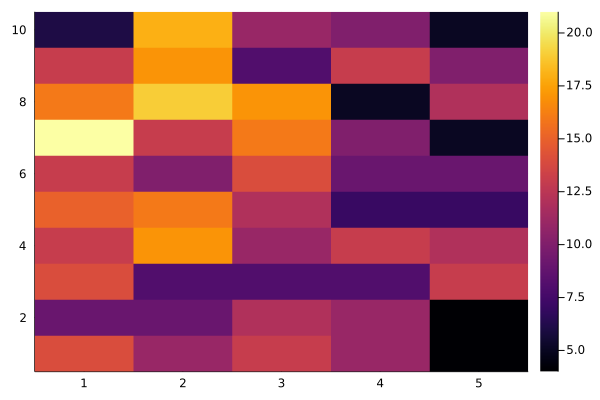

In [375]:
heatmap(s_m)

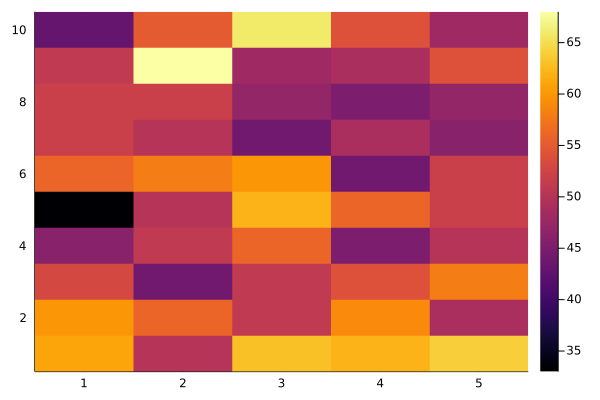

In [355]:
a_m = reshape(counts(a, 50), (10,5))
heatmap(a_m)

In [357]:
x = JuMP.value.(x);

In [358]:
schedule = reshape(sum(x[i,:] for i=1:ntot), (10,5))

10×5 Matrix{Float64}:
 29.0  26.0  25.0  22.0  11.0
 29.0  22.0  22.0  21.0  11.0
 31.0  22.0  16.0  19.0  21.0
 25.0  23.0  24.0  22.0  18.0
 25.0  30.0  22.0  22.0  14.0
 30.0  25.0  27.0  17.0  18.0
 33.0  23.0  20.0  18.0  13.0
 28.0  28.0  23.0  16.0  19.0
 26.0  32.0  17.0  22.0  21.0
 20.0  29.0  25.0  20.0  15.0

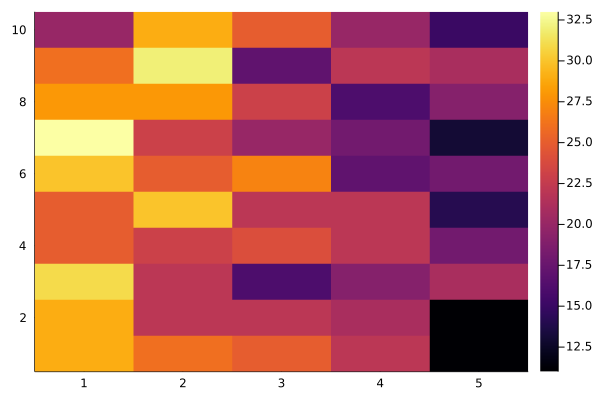

In [359]:
heatmap(schedule)

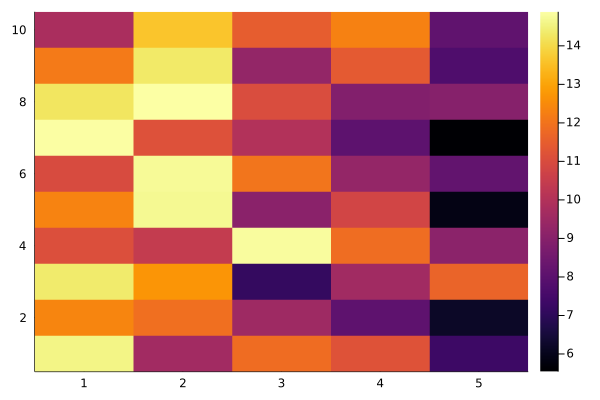

In [360]:
schedule_show = reshape([sum(x[i,j]*p[i,j] for i=1:ntot) for j=1:50], (10,5));
heatmap(schedule_show)

In [361]:
objective_value(model)

0.0

In [362]:
sum([max(sum(x[i,j]*(p[i,j]>0.5) for i=1:ntot) - nd, 0) for j=1:50])

6.0

##### Comparison with random

In [363]:
opti_random = [rand(1:50) for i=1:nb];

In [364]:
x_random = cat(s, opti_random, dims=1);

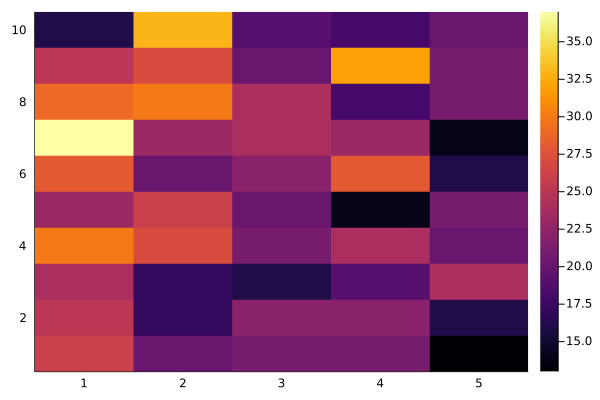

In [365]:
x_random_m = reshape(counts(x_random, 50), (10,5))
heatmap(x_random_m)

In [366]:
x_r = zeros(ntot, 50)
for i = 1:ntot
    for j = 1:50
        if x_random[i]==j
            x_r[i,j]=1
        end
    end
end

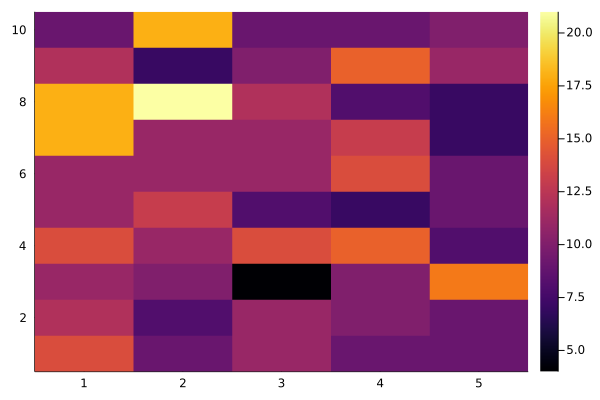

In [367]:
random_show = reshape([sum(x_r[i,j]*(p[i,j]>0.5) for i=1:ntot) for j=1:50], (10,5));
heatmap(random_show)

In [368]:
sum([max(sum(x_r[i,j]*(p[i,j]>0.5) for i=1:ntot) - nd, 0) for j=1:50])

16.0